In [446]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import argparse
import os
from skimage.feature import peak_local_max
import copy

In [447]:
filepath = r"C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay"
imagesFolder = r"Data\Train\Set1"
saveFolder = r"Results\Set1"
showImages = True
useHarris = False
choice = 1 if useHarris else 2 # shi-Tomashi , 1 for Harris corner

In [448]:
# read the images
def readImages(filepath: str):
    print('Reading from: ', filepath)
    images = []
    files = os.listdir(filepath)
    sorted(files)
    for file in files:
        imagePath = os.path.join(filepath, file)
        image = cv2.imread(imagePath)
        if image is not None:
            images.append(image)
    print('Read ', len(images), ' images')
    return images

In [449]:
def makeImagesSizeSame(images:list[np.ndarray])->list[np.ndarray]:
    sizeList = []
    for image in images:
        x, y, ch = image.shape
        sizeList.append([x, y, ch])
    sizeArr = np.array(sizeList)
    r, c, ch = np.max(sizeArr, axis=0)
    newImages = []
    for i, image in enumerate(images):
        resized = np.zeros((r, c, sizeArr[i, 2]), np.uint8)
        resized[0:sizeArr[i, 0], 0:sizeArr[i, 1], 0:sizeArr[i, 2]] = image
        newImages.append(resized)
    return newImages
    

In [450]:
def displayImages(images:list[np.ndarray], fileName:str):
    newImages = makeImagesSizeSame(images)
    concatenated = newImages[0].copy()
    for i in range(1, len(newImages)):
        concatenated = np.concatenate((concatenated, newImages[i]), axis=1)
    cv2.imshow(fileName, concatenated)
    cv2.waitKey()
    cv2.destroyAllWindows()
    print('Writing file to ', fileName)
    cv2.imwrite(fileName, concatenated)    

In [451]:
images = readImages(os.path.join(filepath, imagesFolder))
if showImages:
    displayImages(images, os.path.join(filepath, saveFolder, 'concatenated.png'))

Reading from:  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Data\Train\Set1
Read  3  images
Writing file to  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Results\Set1\concatenated.png


In [452]:
# total images
N_images = len(images)
# split in sets
N_first_half = round(N_images/2)
N_second_half = N_images - N_first_half
print('Splitting total images in sets of', N_first_half, ',and', N_second_half)

Splitting total images in sets of 2 ,and 1


In [453]:
def detectCorners(images:list[np.ndarray], choice:int):
    print('Detecting Corners...')
    detectedCorners = []
    cmaps = []
    corner_images = []
    for image in images:
        gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        if choice == 1:
            print("Harris corner detection method.")
            corner_strength = cv2.cornerHarris(gray_image,2,3,0.001)
            corner_strength[corner_strength<0.01*corner_strength.max()] = 0
            cmaps.append(corner_strength)
            detected_corner = np.where(corner_strength>0.0001*corner_strength.max())
            detectedCorners.append(detected_corner)
            image[detected_corner] = [0,0,255]
            corner_images.append(image)
        else:
            print("Shi-Tomashi corner detection method.")
            dst = cv2.goodFeaturesToTrack(gray_image, 1000 ,0.01, 10)
            dst = np.int0(dst)
            detectedCorners.append(dst)
            for corner in dst:
                x, y = corner.ravel()
                cv2.circle(image, (x, y) ,3 ,(0, 0, 255), -1)
            corner_images.append(image)
            # cmap not used for shi-tomashi
            cmap = np.zeros(gray_image.shape)
            cmaps.append(cmap)
    return detectedCorners, cmaps, corner_images
            


In [454]:
def show(image):
    cv2.imshow('Image', image)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [455]:
detectedCorners, cmaps, cornerImages = detectCorners(copy.deepcopy(images), choice=choice)

Detecting Corners...
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.


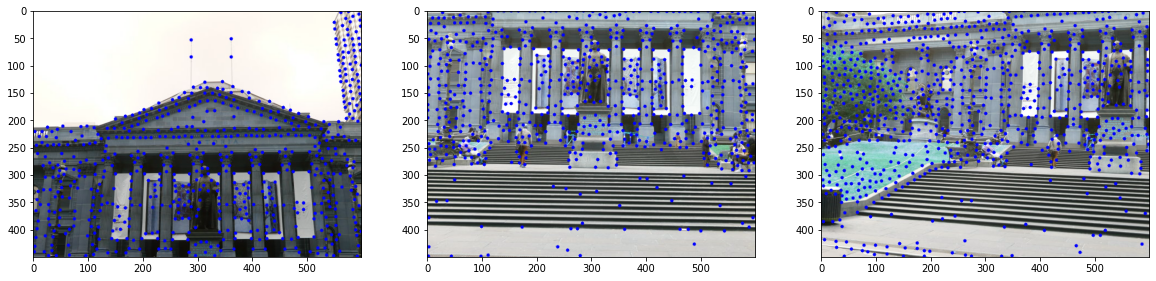

In [456]:
fig, ax = plt.subplots(1, len(cornerImages), figsize=(20,5))
for i in range(len(cornerImages)):
    ax[i].imshow(cornerImages[i])

In [457]:
def AdaptiveNonMaximalSupression(images:list[np.ndarray], Cmaps:list[np.ndarray], N_best:int):
    anms_images = []
    anms_corners = []
    for i, image in enumerate(images):
        cmap = Cmaps[i]
        local_max = peak_local_max(cmap, min_distance=15)
        n_strong = local_max.shape[0]
        r = [np.inf for i in range(n_strong)]
        dist = 0
        final = np.zeros((n_strong, 2), dtype=int)
        
        for i in range(n_strong):
            for j in range(n_strong):
                x_i = local_max[i][0]
                y_i = local_max[i][1]

                x_j = local_max[j][0]
                y_j = local_max[j][1]

                if (cmap[x_j,y_j] > cmap[x_i, y_i]):
                    dist = np.square(x_i-x_j) + np.square(y_i-y_j)
                if (dist < r[i]):
                    r[i] = dist
                    final[i, 0] = y_j
                    final[i, 1] = x_j
        
        if n_strong < N_best:
            N_best = n_strong
        index = np.argsort(r)
        index = np.flip(index)
        index = index[:N_best]
        final = final[index]
        for cx, cy in final:
            cv2.circle(image, (cx, cy), 4, (255, 0, 0), -1)
        anms_images.append(image)
        anms_corners.append(final)

    return anms_corners, anms_images

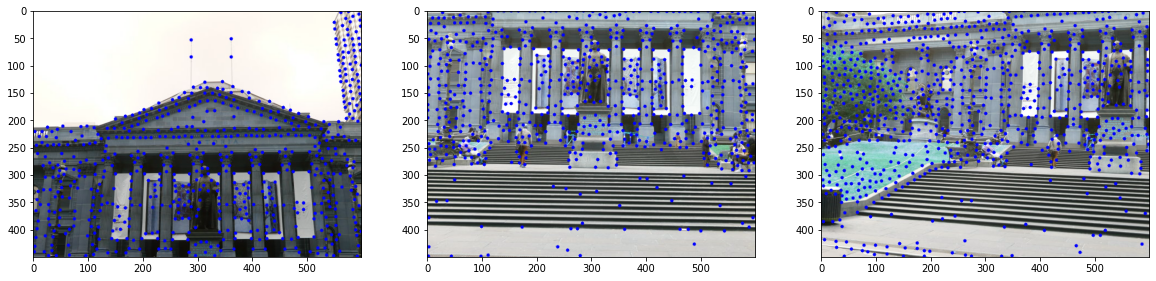

In [458]:
if (choice == 1):
    anms_corners, anms_images = AdaptiveNonMaximalSupression(copy.deepcopy(images), cmaps, 300)
else:
    anms_corners, anms_images = detectedCorners, cornerImages
fig, ax = plt.subplots(1, len(anms_images), figsize=(20,5))
for i in range(len(anms_images)):
    ax[i].imshow(anms_images[i])

In [459]:
def getFeatureDescriptor(image, col, row, path_size=40):
    patch = image[col - path_size//2: col + path_size//2 , row - path_size//2: row + path_size//2]
    # gaussian blur
    patch = cv2.GaussianBlur(patch, (3,3), 0)
    # subsample to 20%
    patch = cv2.resize(patch, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)
    # flatten the patch
    feature = patch.reshape(-1)
    # zero mean and unit std
    feature = (feature - np.mean(feature)) / np.std(feature)
    return feature

In [460]:
def checkAndGetFeature(corners: list[np.ndarray], image:np.ndarray, patch_size=40):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    width, height = image.shape
    features = []
    final_corners = []
    for corner in corners:
        x, y = corner.ravel()
        if (x - patch_size/2 > 0 and x + patch_size/2 < height
            and y - patch_size/2 > 0 and y + patch_size/2 < width):
            features.append(getFeatureDescriptor(image, y, x, patch_size))
            final_corners.append([x, y])
    return features, final_corners
        

In [461]:
def getPairs(img1, img2, corners1, corners2, patch_size=40):
    features = []
    corners = []
    
    feature, corner = checkAndGetFeature(corners1, img1, patch_size=patch_size)
    features.append(feature)
    corners.append(corner)

    feature, corner = checkAndGetFeature(corners2, img2, patch_size=patch_size)
    features.append(feature)
    corners.append(corner)

    matched_pairs = []
    for i, feature1 in enumerate(features[0]):
        ssd = []
        for j, feature2 in enumerate(features[1]):
            ssd.append(np.sum((feature1 - feature2)**2))
        best_match = np.argmin(ssd)
        matched_pairs.append([corners[0][i], corners[1][best_match]])
    print("Matched pairs between two images: ", len(matched_pairs))
    return np.array(matched_pairs)

In [462]:
def showMatches(img1, img2, matched_pairs, filename):
    image1 = copy.deepcopy(img1)
    image2 = copy.deepcopy(img2)
    image1, image2 = makeImagesSizeSame([image1, image2])
    concat = np.concatenate((image1, image2), axis = 1)
    corners_1 = matched_pairs[:,0].copy()
    corners_2  = matched_pairs[:,1].copy()
    corners_2[:,0] += image1.shape[1]

    for (x1,y1) , (x2,y2) in zip(corners_1, corners_2):
        cv2.line(concat, (x1,y1), (x2,y2), (0, 0, 255), 1)
    cv2.imshow(filename, concat)
    cv2.waitKey() 
    cv2.destroyAllWindows()
    return concat

Matched pairs between two images:  517


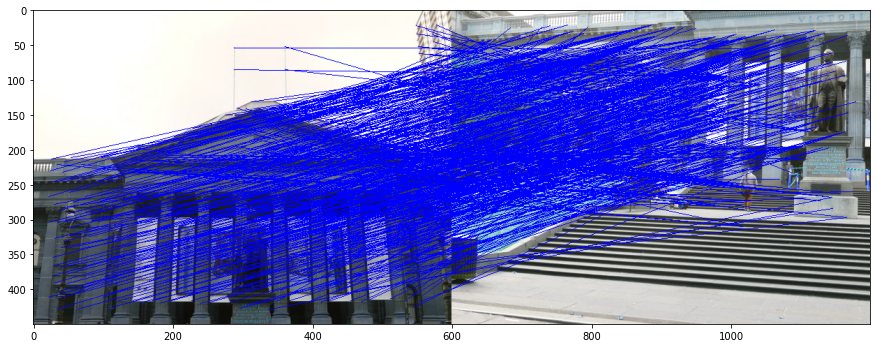

In [468]:
matched_pairs = getPairs(images[0], images[2], anms_corners[0], anms_corners[2])
matched = showMatches(images[0], images[2], matched_pairs, "matches")
plt.figure(figsize=(15,15))
plt.imshow(matched)

In [464]:
def calcError(set1: np.ndarray, set2:np.ndarray):
    return np.linalg.norm(set1-set2, axis=1)

In [465]:
def filterOutliers(matched_pairs:np.ndarray, threshold=5):
    set1 = matched_pairs[:, 0]
    set2 = matched_pairs[:, 1]
    N_best = np.inf
    H_best = np.zeros((3,3))
    iterations = 8000
    threshold = 5
    best_matches = []
    for i in range(iterations):
        # randomly select 4 rows
        n_rows = set1.shape[0]
        random_idx = np.random.choice(n_rows, size=4)
        set1_random = set1[random_idx]
        set2_random = set2[random_idx]

        #compute Homography
        H = cv2.getPerspectiveTransform(np.float32(set1_random), np.float32(set2_random))
        
        # multiply with the source point to predict the target
        set1_dash = np.vstack((set1[:,0], set1[:,1], np.ones((1, n_rows))))
        set2_pred = np.dot(H, set1_dash)
        x_pred = set2_pred[0, :] / (set2_pred[2, :] + 1e-10)
        y_pred = set2_pred[1, :] / (set2_pred[2, :] + 1e-10)
        set2_pred = np.array([x_pred, y_pred]).T
        E = calcError(set2_pred, set2)
        E[E <= threshold] = 0
        E[E > threshold] = 1
        outliers = np.sum(E)
        if outliers < N_best:
            N_best = outliers
            H_best = H
            best_matches = np.where(E == 0)
        
    final_set1 = set1[best_matches]
    final_set2 = set2[best_matches]

    print("Final Good Matches: ", final_set1.shape[0])

    final_matches = np.zeros((final_set1.shape[0], 2, 2))
    # match from 1st image
    final_matches[:, 0, :] = final_set1
    # correspondence in 2nd image
    final_matches[:, 1, :] = final_set2
    final_matches = final_matches.astype(int)

    return H_best, final_matches

Final Good Matches:  96


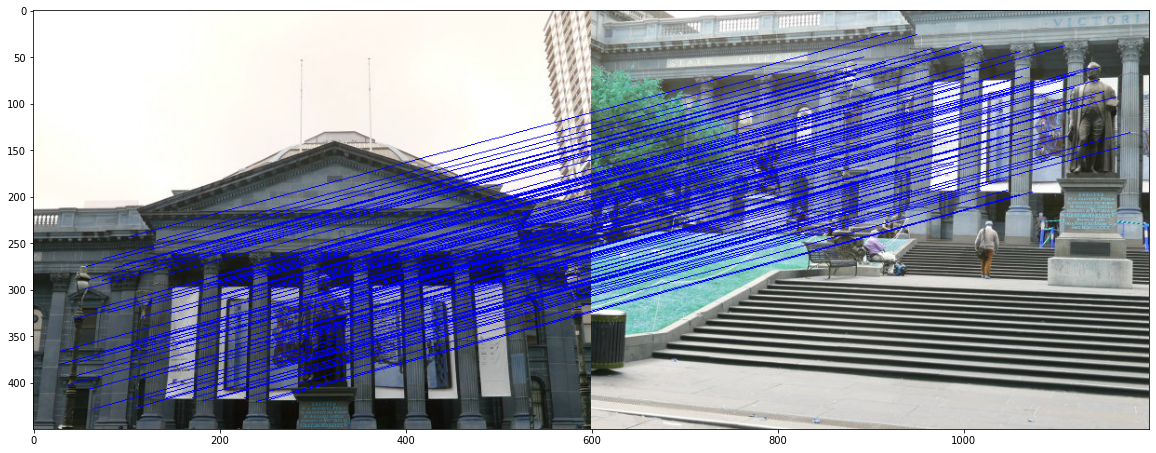

In [466]:
H, final_matches = filterOutliers(matched_pairs, threshold=5)
img_match = showMatches(images[0], images[2], final_matches, "final matches")
plt.figure(figsize=(20,20))
plt.imshow(img_match)
